In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Data
eddies = np.load('../../eddies_last.npy').item()
ADCPs = np.load('ADCPS.npy').item()

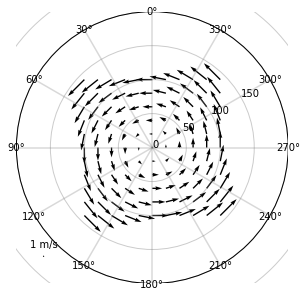

In [3]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()

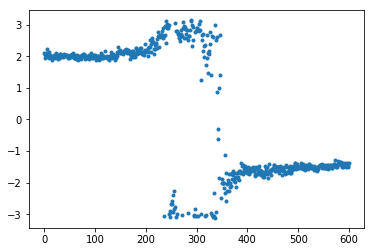

In [9]:
plt.plot(Angles_me,'.')

A filter should be applied directly to the data with 3 dimensions

In [3]:
ADCP = ADCPs['V1']

In [28]:
lon = ADCP['longitudes']
lat = ADCP['latitudes']
depths = ADCP['depths']
V = ADCP['V']
U = ADCP['U']
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)
grid = 4000
atd = analysis.ComputeATD(lon,lat,m=m)
V_reg,x_reg,yreg = analysis.RegularGrid2D(V,x,y,grid)
U_reg,x_reg,y_reg = analysis.RegularGrid2D(U,x,y,grid)
V_reg_filt = analysis.BoxCarFilter(V_reg,5,3)
U_reg_filt = analysis.BoxCarFilter(U_reg,5,3)

/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/analysis.py:74: RuntimeWarning: Mean of empty slice
  wcolumn = np.nanmean(matrix[data_index,:],axis=0)


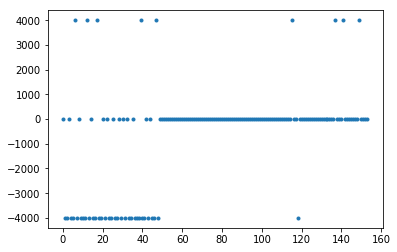

In [32]:
plt.plot(yreg[1:]-yreg[:-1],'.')

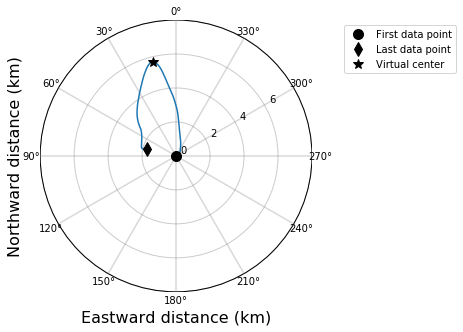

In [26]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
plottools.Hodograph(ax,8)
plottools.PlotHodograph(ax,U_reg_filt,V_reg_filt,10)

In [ ]:
lon = ADCP['longitudes']
lat = ADCP['latitudes']
depths = ADCP['depths']
V = ADCP['V']
U = ADCP['U']
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)
grid = 4000
atd = analysis.ComputeATD(lon,lat,m=m)
V_reg,x_reg,yreg = analysis.RegularGrid2D(V,x,y,grid)
U_reg,x_reg,y_reg = analysis.RegularGrid2D(U,x,y,grid)
V_reg_filt = analysis.BoxCarFilter(V_reg,5,3)
U_reg_filt = analysis.BoxCarFilter(U_reg,5,3)

In [3]:
M = np.zeros((3,3,3))

In [13]:
M[0,0,0] = 1
M[0,1,1] = 1
M[0,2,2] = 1
M[1,0,0] = 1
M[1,1,1] = 1
M[1,2,2] = 1
M[2,0,0] = 1
M[2,1,1] = 1
M[2,2,2] = 1

In [15]:
M[np.where(M == 1)]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
ADCP = ADCPs['V1']
lon = ADCP['longitudes']
lat = ADCP['latitudes']
depths = ADCP['depths']
V = ADCP['V']
U = ADCP['U']
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)
atd = analysis.ComputeATD(lon,lat,m=m)

In [7]:
V_filt = analysis.BoxCarFilter2(V,x,y,depths,20e3,20e3,150)

/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/analysis.py:231: RuntimeWarning: Mean of empty slice
  val = np.nanmean(Mf[indexes])


In [8]:
X = []
Y = []
Z = []
# Vl = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(x[i])
        Y.append(y[i])
        Z.append(depths[j])
#         Vl.append(V[i,j])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
# Vl = np.array(Vl)
Vlf = V_filt.flatten()

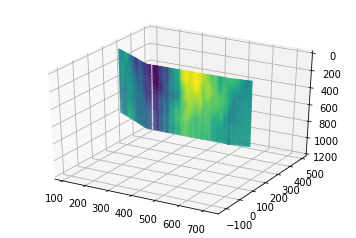

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_yticks(np.arange(100,250,10))
# ax.set_xticks(np.arange(100,700,10))
# ax.set_xlim(100,700)
# ax.set_ylim(100,250)
ax.set_zlim(1200,0)
s = ax.scatter(X/1000,Y/1000,Z,c=Vlf,s=0.8)
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb in zip(Xb, Yb):
    ax.plot([xb/1000], [yb/1000], [0], 'w')